In [23]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")



Trivertex_classical_ising_partition_function (generic function with 2 methods)

In [24]:
# some single qubit gates

function single_gate_ry(theta)
    """
    Create a rotation about the y axis: theta [0, 4π]
    """

    c = cos(theta/2)
    s = sin(theta/2)

    gate = [c -s; s c]

    return gate

end

function rel_phase(theta)
    """
    Create a phase shift: theta [0, 2π]
    """
    gate = [1 0; 0 exp(im*theta)]
    return gate
end

function hadamard()
    gate = 1/sqrt(2)*[1 1; 1 -1]
    return gate
end

function xnot()
    gate = [0 1 ; 1 0]
    return gate
end


ry = single_gate_ry(pi/2)
display(ry)
display(rel_phase(1))
h = hadamard()
display(h)
display(xnot())


# some two qubit gates

function xx_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    c = cos(theta/2)
    s = sin(theta/2)
    gate = [c 0 0 -im*s ; 0 c -im*s 0; 0 -im*s c 0; -im*s 0 0 c]
    return gate
end

function yy_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    c = cos(theta/2)
    s = sin(theta/2)
    gate = [c 0 0 im*s ; 0 c -im*s 0; 0 -im*s c 0; im*s 0 0 c]
    return gate
end

function zz_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    p = exp(+im*theta/2)
    m = exp(-im*theta/2)
    gate = [m 0 0 0; 0 p 0 0; 0 0 p 0; 0 0 0 m]
    return gate
end

display(xx_interaction(pi/2))
display(yy_interaction(pi/2))
display(zz_interaction(pi/2))

2×2 Matrix{Float64}:
 0.707107  -0.707107
 0.707107   0.707107

2×2 Matrix{ComplexF64}:
 1.0+0.0im       0.0+0.0im
 0.0+0.0im  0.540302+0.841471im

2×2 Matrix{Float64}:
 0.707107   0.707107
 0.707107  -0.707107

2×2 Matrix{Int64}:
 0  1
 1  0

4×4 Matrix{ComplexF64}:
 0.707107+0.0im            0.0+0.0im       …       0.0-0.707107im
      0.0+0.0im       0.707107+0.0im               0.0+0.0im
      0.0+0.0im            0.0-0.707107im          0.0+0.0im
      0.0-0.707107im       0.0+0.0im          0.707107+0.0im

4×4 Matrix{ComplexF64}:
 0.707107+0.0im            0.0+0.0im       …       0.0+0.707107im
      0.0+0.0im       0.707107+0.0im               0.0+0.0im
      0.0+0.0im            0.0-0.707107im          0.0+0.0im
      0.0+0.707107im       0.0+0.0im          0.707107+0.0im

4×4 Matrix{ComplexF64}:
 0.707107-0.707107im       0.0+0.0im       …       0.0+0.0im
      0.0+0.0im       0.707107+0.707107im          0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im          0.707107-0.707107im

In [25]:
function sq_gt(input_data, index_in, index_out)
    """
    single qubit gate tensor
    input data is the gate which is applied, index_in and index_out are 2 dimensional index-symbols
    """
    single_gate_tensor = Tenet.Tensor(input_data, [index_in, index_out])
    return single_gate_tensor
end

function tq_gt(input_data, index_in, index_out)
    """
    double qubit gate tensor
    """
    tensorized_data = reshape(input_data, 2, 2, 2, 2)
    double_gate_tensor = Tenet.Tensor(tensorized_data, [index_in..., index_out...])
    return double_gate_tensor
end

t1 = sq_gt(rel_phase(pi)/2, :s, :i)
t2 = tq_gt(xx_interaction(pi/2), [:a, :b], [:c, :d])



2×2×2×2 Tensor{ComplexF64, 4, Array{ComplexF64, 4}}:
[:, :, 1, 1] =
 0.707107+0.0im  0.0+0.0im
      0.0+0.0im  0.0-0.707107im

[:, :, 2, 1] =
      0.0+0.0im  0.0-0.707107im
 0.707107+0.0im  0.0+0.0im

[:, :, 1, 2] =
 0.0+0.0im       0.707107+0.0im
 0.0-0.707107im       0.0+0.0im

[:, :, 2, 2] =
 0.0-0.707107im       0.0+0.0im
 0.0+0.0im       0.707107+0.0im

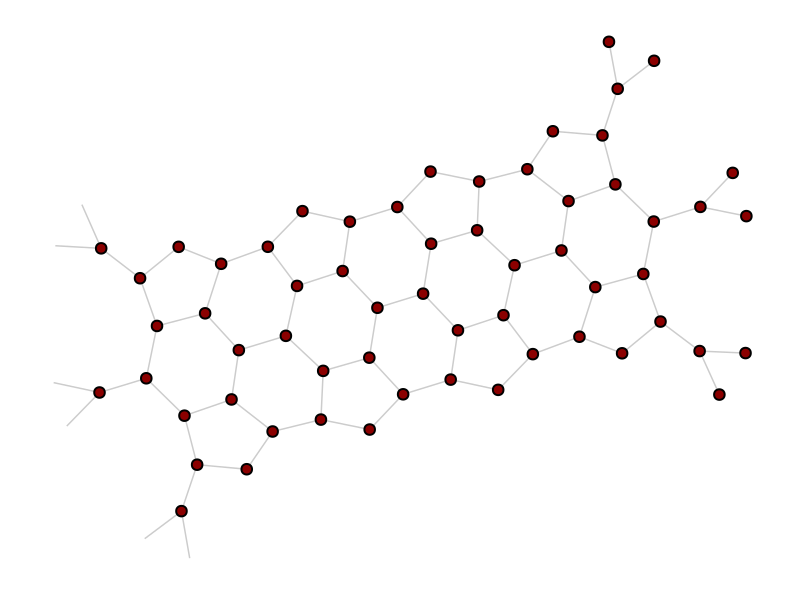

CairoMakie.Screen{IMAGE}


In [26]:
function generate_random_quantum_circuit(num_q, layers, theta)
    #symbols from 1 - 1000
    unique_symbols = [Symbol(i) for i in 1:1000]
    # prep_z state for the initial_state: all qubits in |0>
    initial_state = [1, 0]
    tensors_in_network = []
    for i in 1:num_q
        push!(tensors_in_network, Tenet.Tensor(initial_state, [popfirst!(unique_symbols)]))
    end
    previous_layer_inds = [inds(tensor)[1] for tensor in tensors_in_network[end-num_q+1:end]]
    
    for j in 1:layers
        # add a layer of two qubit tensors entangling all pairs
        if j % 2 == 1
            datas = [xx_interaction(theta), yy_interaction(theta), zz_interaction(theta)]
            for pair in Iterators.partition(previous_layer_inds, 2)
                push!(tensors_in_network, tq_gt(rand(datas), pair, [popfirst!(unique_symbols), popfirst!(unique_symbols)]))
            end
            previous_layer_inds = [id for tensor in tensors_in_network[end-Int(num_q/2)+1:end] for id in inds(tensor)[3:4]]
            #println(previous_layer_inds)
        end
        if j % 2 == 0
            theta = rand(0:4*pi)
            datas1 = [single_gate_ry(theta), rel_phase(theta/2), hadamard(), xnot()]
            datas2 = [xx_interaction(theta), yy_interaction(theta), zz_interaction(theta)]
            id1 = popfirst!(previous_layer_inds)
            push!(tensors_in_network, sq_gt(rand(datas1), id1, popfirst!(unique_symbols)))
            for pair in Iterators.partition(previous_layer_inds[1:Int(num_q-2)], 2)
                push!(tensors_in_network, tq_gt(rand(datas2), pair, [popfirst!(unique_symbols), popfirst!(unique_symbols)]))
            end
            id10 = previous_layer_inds[end]
            push!(tensors_in_network, sq_gt(rand(datas1), id10, popfirst!(unique_symbols)))
            previous_layer_inds = [id for tensor in tensors_in_network[end-Int(num_q/2)+1:end-1] for id in inds(tensor)[3:4]]
            #println("previous_layer_inds = ", previous_layer_inds)
            pushfirst!(previous_layer_inds, inds(tensors_in_network[end-Int(num_q/2)])[2])
            push!(previous_layer_inds, inds(tensors_in_network[end])[2])
            #println(previous_layer_inds)
        end
    
    end
    
    TN = Tenet.TensorNetwork(tensors_in_network)
    for tensor in Tenet.tensors(TN)
        rank = length(inds(tensor))
        if rank > 3 #remove the bulk tesnors and replace them with new QR  tensors
            pop!(TN, tensor)
            Q, R = LinearAlgebra.qr(tensor, left_inds=inds(tensor)[1:2])
            push!(TN, Q)
            push!(TN, R)
        end
    end
    return TN

end

tn1 = generate_random_quantum_circuit(6, 9, 1)
drawing1 = Makie.plot(tn1, node_color=[:darkred for i in 1:length(tensors(tn1))], layout=Stress(), edge_color=:grey80)
display(drawing1)





